In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import backend as K

2024-07-04 09:50:14.855234: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 09:50:15.205397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 09:50:16.179618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


2024-07-04 09:50:18.059124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 09:50:18.236446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 09:50:18.240497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Activer la précision mixte
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [4]:
# Nettoyage de la mémoire (au cas où :D)
K.clear_session()

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 50
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

In [6]:
# Utiliser image_dataset_from_directory pour charger les datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Appliquer le prétraitement spécifique à VGG16
def preprocess(image, label):
    return preprocess_input(image), label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 12484 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


In [7]:
# Augmentation des données
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten(name='new_flatten')(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
classifieur = Dense(3, activation='softmax', dtype='float32')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS

new_model = Model(inputs=base_model.input, outputs=classifieur)

In [9]:
# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

In [10]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 6,490,371 (24.76 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [11]:
# Callbacks pour l'entraînement
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

In [12]:
lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
es = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [14]:
history = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=[es, reduce_lr, lr_scheduler],
    shuffle=True
)

Epoch 1/50


I0000 00:00:1720079428.441069    5108 service.cc:145] XLA service 0x7d091c023b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720079428.441322    5108 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-07-04 09:50:28.596106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-04 09:50:28.888722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   4/1561 ━━━━━━━━━━━━━━━━━━━━ 1:18 50ms/step - accuracy: 0.2161 - loss: 2.4709 - recall: 0.2161

I0000 00:00:1720079435.337000    5108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1561/1561 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.5522 - loss: 1.9519 - recall: 0.5295 - val_accuracy: 0.6806 - val_loss: 1.5752 - val_recall: 0.6562 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6533 - loss: 1.5911 - recall: 0.6312 - val_accuracy: 0.7014 - val_loss: 1.3766 - val_recall: 0.6806 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6909 - loss: 1.4437 - recall: 0.6720 - val_accuracy: 0.6632 - val_loss: 1.3977 - val_recall: 0.6458 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.7069 - loss: 1.3416 - recall: 0.6868 - val_accuracy: 0.7465 - val_loss: 1.1900 - val_recall: 0.7292 - learning_rate: 1.0000e-04
Epoch 5/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7169 - loss: 1.2654 - recall: 0.6957 - val_accuracy: 0.7951 - val_loss: 1.1241 - val_recall: 0.7674 - learning_rate: 1.0000e-04
Epoch 6/50
1561/1561 

In [15]:
# Dégelez les dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [16]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 13,569,795 (51.76 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [17]:
history_finetune = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=20,
    callbacks=[es, reduce_lr, lr_scheduler],
    shuffle=True
)

Epoch 1/20


1561/1561 ━━━━━━━━━━━━━━━━━━━━ 104s 64ms/step - accuracy: 0.7934 - loss: 0.6738 - recall_1: 0.7788 - val_accuracy: 0.7708 - val_loss: 0.7171 - val_recall_1: 0.7674 - learning_rate: 1.0000e-05
Epoch 2/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.8143 - loss: 0.6284 - recall_1: 0.8016 - val_accuracy: 0.7604 - val_loss: 0.7018 - val_recall_1: 0.7569 - learning_rate: 1.0000e-05
Epoch 3/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.8209 - loss: 0.5992 - recall_1: 0.8093 - val_accuracy: 0.7500 - val_loss: 0.7068 - val_recall_1: 0.7465 - learning_rate: 1.0000e-05
Epoch 4/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.8211 - loss: 0.5956 - recall_1: 0.8098 - val_accuracy: 0.7674 - val_loss: 0.7064 - val_recall_1: 0.7604 - learning_rate: 1.0000e-05
Epoch 5/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.8239 - loss: 0.5985 - recall_1: 0.8133 - val_accuracy: 0.7639 - val_loss: 0.7735 - val_recall_1: 0.7639 - learning_rate: 2.0000e-06


In [18]:
# Dégelez les 8 dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [19]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 19,469,571 (74.27 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [20]:
history_finetune_2 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs= 30, 
    callbacks=[es, reduce_lr, lr_scheduler],
    shuffle=True
)

Epoch 1/30


2024-07-04 11:03:36.890463: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-04 11:03:37.503912: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 645/1561 ━━━━━━━━━━━━━━━━━━━━ 1:16 83ms/step - accuracy: 0.8629 - loss: 0.5108 - recall_2: 0.8541

2024-07-04 11:04:34.087667: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-04 11:04:34.379795: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1561/1561 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.8613 - loss: 0.5138 - recall_2: 0.8531 - val_accuracy: 0.7743 - val_loss: 0.7068 - val_recall_2: 0.7743 - learning_rate: 1.0000e-06
Epoch 2/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.8620 - loss: 0.5177 - recall_2: 0.8551 - val_accuracy: 0.7882 - val_loss: 0.6848 - val_recall_2: 0.7812 - learning_rate: 1.0000e-06
Epoch 3/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.8685 - loss: 0.5038 - recall_2: 0.8600 - val_accuracy: 0.7917 - val_loss: 0.6833 - val_recall_2: 0.7882 - learning_rate: 1.0000e-06
Epoch 4/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.8740 - loss: 0.4961 - recall_2: 0.8660 - val_accuracy: 0.7847 - val_loss: 0.7042 - val_recall_2: 0.7812 - learning_rate: 1.0000e-06
Epoch 5/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.8731 - loss: 0.4975 - recall_2: 0.8656 - val_accuracy: 0.7639 - val_loss: 0.7003 - val_recall_2: 0.7535 - learning_rate: 1.0000e

In [21]:
# Fine-tuning final avec toutes les couches dégélées
for layer in base_model.layers:
    layer.trainable = True

In [22]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 21,205,059 (80.89 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
history_finetune_3 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=[es, reduce_lr, lr_scheduler],
    shuffle=True
)

Epoch 1/50


2024-07-04 11:26:09.299236: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-04 11:26:09.812479: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-07-04 11:26:10.884853: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to alloca

   1/1561 ━━━━━━━━━━━━━━━━━━━━ 6:51:45 16s/step - accuracy: 0.7500 - loss: 0.6691 - recall_3: 0.7500

I0000 00:00:1720085173.988144    5107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



1326/1561 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.8660 - loss: 0.5017 - recall_3: 0.8592

2024-07-04 11:29:30.295360: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-04 11:29:31.164533: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-04 11:29:31.885874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1327/1561 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - accuracy: 0.8660 - loss: 0.5017 - recall_3: 0.8592

I0000 00:00:1720085374.029083    5106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



1561/1561 ━━━━━━━━━━━━━━━━━━━━ 252s 151ms/step - accuracy: 0.8657 - loss: 0.5027 - recall_3: 0.8587 - val_accuracy: 0.7812 - val_loss: 0.6950 - val_recall_3: 0.7743 - learning_rate: 1.0000e-07
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - accuracy: 0.8709 - loss: 0.4976 - recall_3: 0.8633 - val_accuracy: 0.7708 - val_loss: 0.7058 - val_recall_3: 0.7639 - learning_rate: 1.0000e-07
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 228s 146ms/step - accuracy: 0.8672 - loss: 0.4977 - recall_3: 0.8618 - val_accuracy: 0.7604 - val_loss: 0.6990 - val_recall_3: 0.7535 - learning_rate: 1.0000e-07
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - accuracy: 0.8638 - loss: 0.5029 - recall_3: 0.8563 - val_accuracy: 0.7569 - val_loss: 0.6974 - val_recall_3: 0.7535 - learning_rate: 1.0000e-07
Epoch 5/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 227s 145ms/step - accuracy: 0.8613 - loss: 0.5160 - recall_3: 0.8533 - val_accuracy: 0.7569 - val_loss: 0.6985 - val_recall_3: 0.7535 - learning_rate: 1.

In [24]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8975 - loss: 0.5381 - recall_3: 0.8853
Loss on test dataset: 0.7794225215911865
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7895377278327942


In [25]:
# Sauvegarder le modèle
new_model.save('3_modele_final_fine_tuning_updated1.keras')

In [26]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [27]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

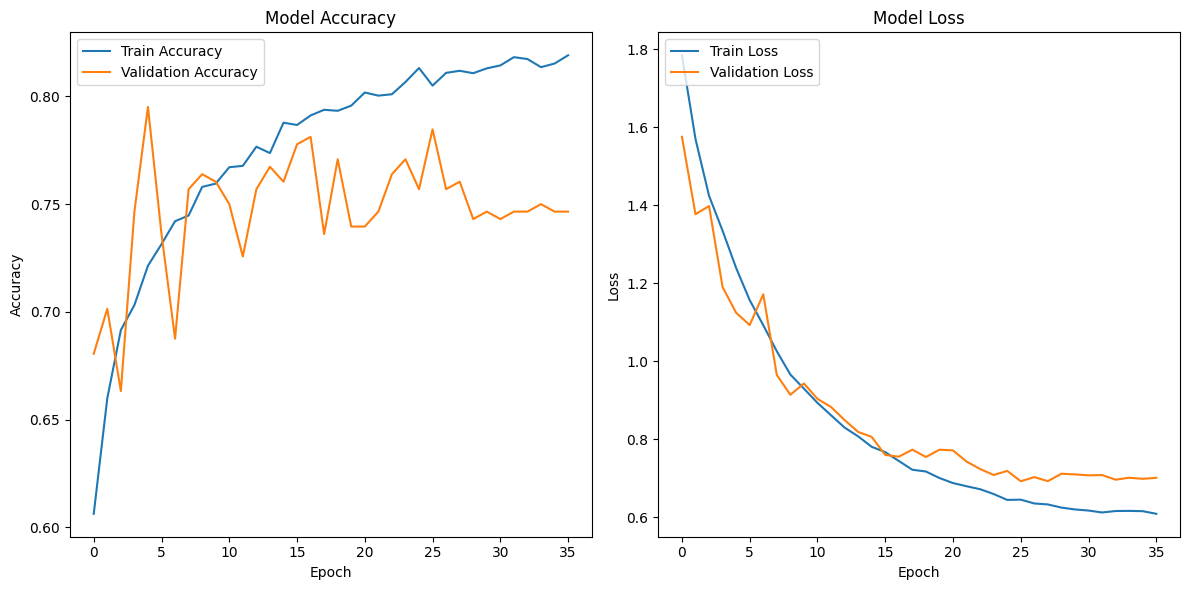

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8975 - loss: 0.5381 - recall_3: 0.8853
Loss on test dataset: 0.7794225215911865
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7895377278327942


2024-07-04 12:04:26.823818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


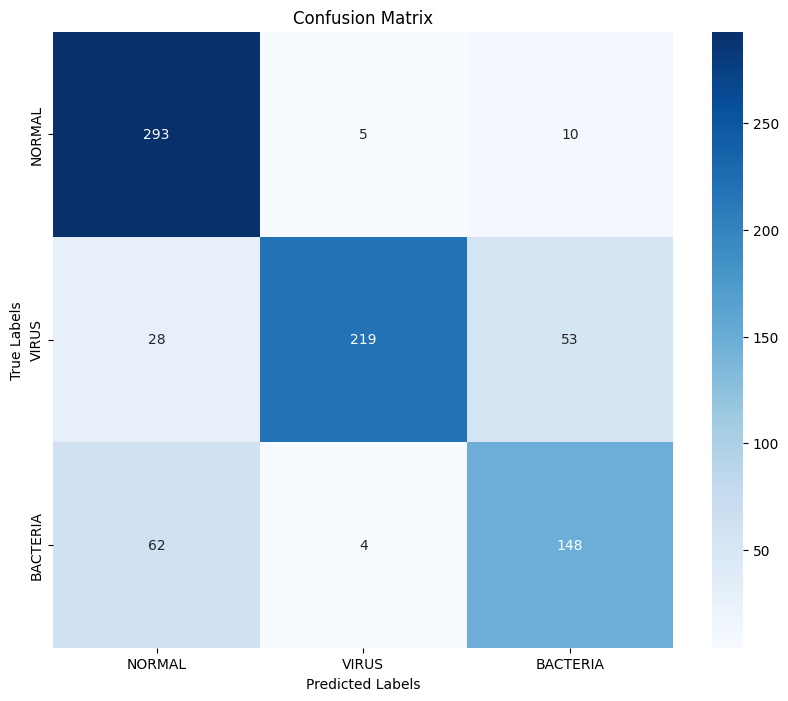

              precision    recall  f1-score   support

      NORMAL       0.77      0.95      0.85       308
       VIRUS       0.96      0.73      0.83       300
    BACTERIA       0.70      0.69      0.70       214

    accuracy                           0.80       822
   macro avg       0.81      0.79      0.79       822
weighted avg       0.82      0.80      0.80       822



In [28]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)